# Modelo Ejemplo

In [1]:
from platform import python_version
  
  
print("Current Python Version-", python_version())

Current Python Version- 3.6.13


In [2]:
#!pip install statsmodels
#!pip install matplotlib

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

In [4]:
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

In [5]:
#Compute Seasonal Index

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

In [6]:
df.head()

,value,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141


In [7]:
#!pip install pmdarima

In [8]:


# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True, #
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=536.818, Time=0.86 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=561.407, Time=0.22 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=538.817, Time=3.07 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=545.106, Time=0.96 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=539.902, Time=4.20 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=596.467, Time=0.27 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=531.829, Time=0.88 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=557.198, Time=0.26 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -258.394
Date:                              Thu, 03 Feb 2022   AIC                            530.788
Time:                                      17:47:37   BIC                            553.591
Sample:                                  07-01-1991   HQIC                           540.024
                                       - 06-01-2008                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.1638      0.097      1.686      0.092      -0.027       0.354
seasonal_index  3.634e-07   3.16e+05   1.15e-12      1.000    -6.2e+05     6.2e+05
ar.L1              0.0960      0.043      2.226      0.026       0.011       0.181
ar.L2              0.4148      0.035     11.912      0.000       0.347       0.483
ar.L3              0.3510      0.054      6.546      0.000       0.246       0.456
ma.S.L12          -0.4627      0.058     -7.966      0.000      -0.577      -0.349
sigma2             0.8470      0.057     14.911      0.000       0.736       0.958
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               124.39
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              12.65   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.91e+14. Standard errors may be unstable.
"""

In [9]:
len(np.tile(seasonal_index['seasonal'].values,2).reshape(-1,1))

24

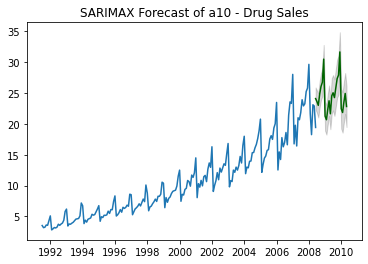

In [10]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous= np.tile(seasonal_index['seasonal'].values,2).reshape(-1,1),
                                  return_conf_int=True
                                 )

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

# Modelo PBI

## Train Test

In [11]:
#!pip install xlrd

In [12]:
#import xlrd
df = pd.read_csv(r'C:\Users\Jair\series.csv', sep = ';')

In [13]:
df.head()

,FECHA,MORA,PBI,Unnamed: 3
0,1,3.2,1.0,NaN
1,2,3.6,1.0,NaN
2,3,3.7,1.0,NaN
3,4,3.9,2.0,NaN
4,5,2.7,3.0,NaN


In [14]:
#De preferencia debe seguir la regla 70 30 
df_train= df[df['FECHA']<=15]
df_test= df[df['FECHA']>15]

In [15]:
df_train

,FECHA,MORA,PBI,Unnamed: 3
0,1,3.2,1.0,NaN
1,2,3.6,1.0,NaN
2,3,3.7,1.0,NaN
3,4,3.9,2.0,NaN
4,5,2.7,3.0,NaN
5,6,2.2,4.0,NaN
6,7,2.4,3.0,NaN
7,8,2.6,3.0,NaN
8,9,3.0,3.5,NaN
9,10,3.5,3.5,NaN


## Modelo

In [16]:
sxmodel = pm.auto_arima(df_train[['MORA']], exogenous=df_train[['PBI']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=4, max_q=4,
                           # , m=12, # Number of season
                           start_P=0, seasonal=False,
                           d=None, D=1, trace=True, #
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=90.074, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=63.646, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=64.785, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=55.397, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=53.406, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.964 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -23.703
Date:                Thu, 03 Feb 2022   AIC                             53.406
Time:                        17:47:38   BIC                             55.531
Sample:                             0   HQIC                            53.384
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2444      0.751      5.653      0.000       2.773       5.716
PBI           -0.4639      0.072     -6.421      0.000      -0.605      -0.322
sigma2         1.3806      0.407      3.396      0.001       0.584       2.177
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.92   Prob(JB):                         0.62
Heteroskedasticity (H):              25.34   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Analisis

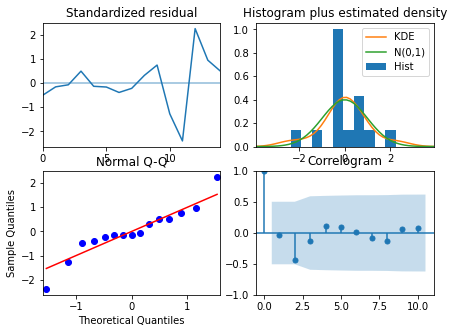

In [17]:
sxmodel.plot_diagnostics(figsize=(7,5))
plt.show()

In [31]:
def prueba_ljungbox(sxmodel):
    p_value=sm.stats.acorr_ljungbox(sxmodel.resid(), lags=[5], return_df=True).iloc[0,1]
    print('The pvalues is:',p_value)
    if p_value > 0.05:
        print('H0: The residuals are independently distributed.')
    elif p_value <=0.05:
        print('HA: The residuals are not independently distributed; they exhibit serial correlation.')
    else:
        print('Error')
    

In [33]:
prueba_ljungbox(sxmodel)

The pvalues is: 0.4619468382519675
H0: The residuals are independently distributed.


## Predicciones

In [36]:
n_periods = len(df) #Pronosticamos para todo el periodo

fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous= np.tile(df['PBI'].values,1).reshape(-1,1), #Importante el reshape
                                  return_conf_int=True #Con intervalos de confinanza
                                 )

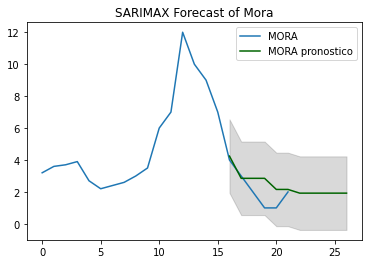

In [19]:

fitted_series = pd.Series(fitted)
lower_series = pd.Series(confint[:, 0])
upper_series = pd.Series(confint[:, 1])

start = min(df_test.index)

fitted_series = fitted_series[fitted_series.index>start]
lower_series = lower_series[lower_series.index>start]
upper_series = upper_series[upper_series.index>start]

# Plot
plt.plot(df['MORA'].dropna(), label='MORA')
plt.plot(fitted_series, color='darkgreen', label='MORA pronostico')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of Mora")
plt.legend()
plt.show()

## Metricas

In [63]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print('the model is about', 1-mape , 'accurate')
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})



In [64]:
actual=df[df['MORA'].index>start]['MORA'].dropna()

In [65]:
actual.index

Int64Index([16, 17, 18, 19, 20, 21], dtype='int64')

In [66]:
predicciones_metricas = pd.DataFrame(actual).join(pd.DataFrame(fitted_series),how='left')
predicciones_metricas.columns=['MORA','MORA_pred']

In [67]:
forecast_accuracy(predicciones_metricas.MORA_pred, predicciones_metricas.MORA)

the model is about 0.39588136260514506 accurate


C:\Users\Jair\anaconda3\envs\jair\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
C:\Users\Jair\anaconda3\envs\jair\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Jair\anaconda3\envs\jair\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Jair\anaconda3\envs\jair\lib\site-packages\ipykernel_launcher.py:12: Fu

{'mape': 0.6041186373948549,
 'me': 0.6860930892515767,
 'mae': 0.7351731706121623,
 'mpe': 0.5877586102746598,
 'rmse': 0.9664746689501814,
 'corr': 0.7808688094430303,
 'minmax': 0.2773642635078092}